<a href="https://colab.research.google.com/github/maadhuvijay/Project-3-AI-Bootcamp/blob/main/Lego_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LEGO Brick Classifier

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import pickle


from PIL import Image
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

In [4]:
!pip install gradio
!pip install pyttsx3
!sudo apt install espeak #Install espeak text-to-speech engine
!sudo apt install espeak-ng

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 130.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  espeak-data libespeak1 libportaudio2 libsonic0
The following NEW packages will be installed:
  espeak espeak-data libespeak1 libportaudio2 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 30 not upgraded.
Need to get 1,382 kB of archives.
After this operation, 3,178 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd

# Importing Data

In [6]:

# Upload a ZIP File and Extract
from google.colab import files
uploaded = files.upload()

Saving data_modify.zip to data_modify.zip


In [7]:

# Unzip the file

import zipfile
import imghdr

zip_file = "data_modify.zip"  # Change to your filename
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/content/images")  # Extract to 'images' folder



In [9]:
#Load images


image_folder = "/content/images/data_modify"
images = []
file_names = []


# Load images only if they are valid image files
for filename in os.listdir(image_folder):
    file_path = os.path.join(image_folder, filename)


    # Check if the file is a valid image
    if os.path.isfile(file_path):
        # Check if the file is a valid image
        if imghdr.what(file_path):
            img = Image.open(file_path)  # Open the image using PIL


            images.append(img)
            file_names.append({"filename": filename})
# Convert to DataFrame

filename_df = pd.DataFrame(file_names, columns=['filename'])

# Display DataFrame

print(f"Loaded {len(images)} images")




Loaded 1132 images


## Pickling the images

In [ ]:
"""
# Mount the images to the drive

drive.mount('/content/drive')

# Open a new file named 'img.pkl' with write permission
with open('/content/drive/My Drive/img.pkl', 'wb') as file:
    # Use pickle.dump to store the list of images
    pickle.dump(images, file)

    """

Mounted at /content/drive


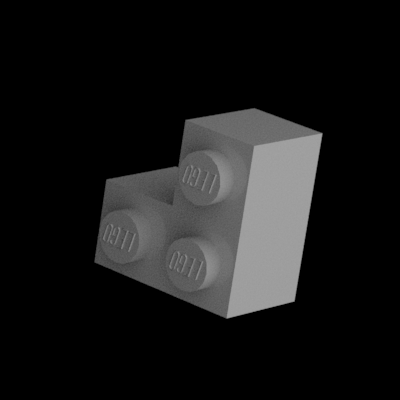

In [ ]:
"""
# Load the images from the pkl file
with open('/content/drive/My Drive/img.pkl', 'rb') as file:
    images = pickle.load(file)

images[800]

"""

In [10]:
from google.colab import drive
import pickle

drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
from tensorflow.keras.models import load_model
# Re-load model
model1 = keras.models.load_model('/content/drive/MyDrive/model1_trained.keras')
#model2 = keras.models.load_model('/content/drive/MyDrive/model2.keras')
model3 = keras.models.load_model('/content/drive/MyDrive/model3_trained.keras')

## Data visualization

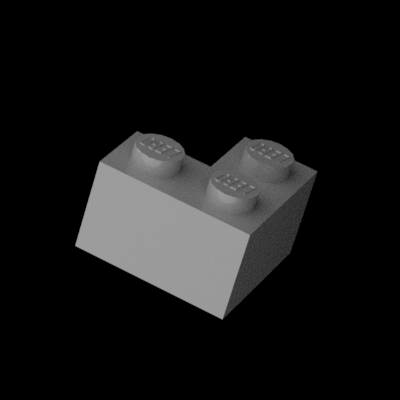

In [13]:
# Print a random image from the list to ensure the import was successful
images[810]

In [14]:
filename_df.iloc[806:,]

,filename
806,3010 brick 1x4 221L.png
807,3022 Plate 2x2 120L.png
808,3022 Plate 2x2 045L.png
809,3001 brick 2x4 258R.png
810,2357 brick corner 1x2x2 114R.png
...,...
1127,3001 brick 2x4 217R.png
1128,3022 Plate 2x2 114L.png
1129,2357 brick corner 1x2x2 054R.png
1130,3010 brick 1x4 225L.png


# Pre-processing Data

In [15]:
# Check the size of an image
images[400].size

(400, 400)

In [16]:
# Check the pixel values of images

print(np.array(images[400]).min(), np.array(images[400]).max())

0 161


In [17]:
# Get all the sizes into a list, then convert to a set
sizes = set([img.size for img in images])
sizes

{(400, 400)}

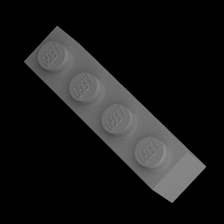

In [18]:
# Use a for loop to resize all images to 224 by 224
target_size = (224,224)

resized_images = [img.resize(target_size, resample = Image.LANCZOS) for img in images]
resized_images[806]

In [19]:
# Verify the resizing of all images
# Get all the sizes into a list, then convert to a set
sizes = set([img.size for img in resized_images])
sizes

{(224, 224)}

### Apply Edge detection, Dilation, Padding to the images

Batched Images Shape: (1132, 224, 224, 3)


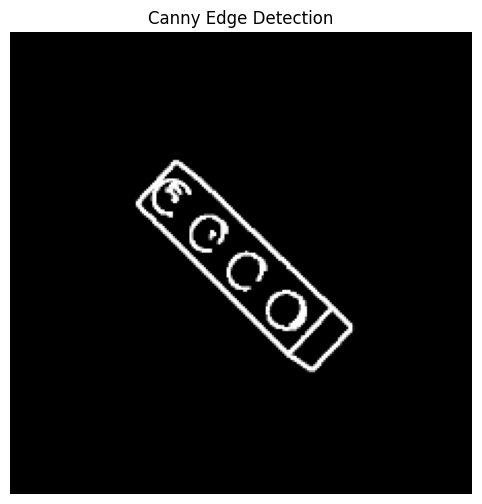

In [22]:

kernel = np.ones((3, 3), np.uint8)

new_images = [np.array(img)  for img in resized_images]
edges=[cv2.Canny(img,50,150) for img in new_images]

dilated_edges = [cv2.dilate(img, kernel, iterations=1) for img in edges]

#Padding

resized_images_input = [cv2.resize(img, (128, 128)) for img in dilated_edges]

  # Add padding to make it 224x224
top = bottom = (224 - 128) // 2
left = right = (224 - 128) // 2
resized_images_input = [np.array(img) for img in resized_images_input]
padded_images = [cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0) for img in resized_images_input]


expanded_edges = [np.stack((img,) * 3, axis=-1) for img in padded_images]
batched_images = np.array(expanded_edges)
print("Batched Images Shape:", batched_images.shape)  # Check the shape


plt.figure(figsize=(8,6))
plt.imshow(batched_images[806], cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")
plt.show()


In [23]:
# Convert to NumPy array and then to float32


float_images = [np.array(img).astype(np.float32) for img in batched_images]
print("Pixel Values:")
print(np.array(float_images[700]).min(), np.array(float_images[700]).max())


Pixel Values:
0.0 255.0


In [24]:
# Normalize pixel values to range [0, 1]
normalized_images = [img/255 for img in float_images]
print("Pixel Values:")
print(np.array(normalized_images[700]).min(), np.array(normalized_images[700]).max())


Pixel Values:
0.0 1.0


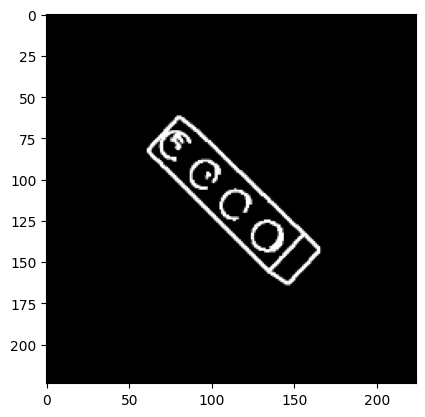

In [25]:
import matplotlib.pyplot as plt

# Display the normalized image
plt.imshow(normalized_images[806])
plt.show()

In [26]:
#check the channel dimensions
normalized_images[400].shape

(224, 224, 3)

In [27]:
# Convert the images to grayscale

import tensorflow as tf

grayscale_images = tf.image.rgb_to_grayscale(normalized_images)


print(grayscale_images.shape)

(1132, 224, 224, 1)


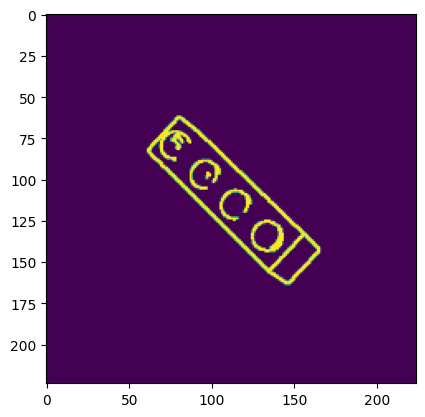

In [28]:
plt.imshow(grayscale_images[806])
plt.show()

In [29]:
#Check the pixels of gray scale images
print("Pixel Values:")
print(np.array(grayscale_images[500]).min(), np.array(grayscale_images[500]).max())


Pixel Values:
0.0 0.99990004


# Labels

In [30]:
filename_df.head()

,filename
0,3010 brick 1x4 228R.png
1,3010 brick 1x4 143L.png
2,3001 brick 2x4 365R.png
3,3001 brick 2x4 244R.png
4,2357 brick corner 1x2x2 072L.png


In [31]:
# Function to handle different filename structures
def split_filename(filename):
    parts = filename.replace('.png', '').split()  # Remove .png if needed and split by space
    design_id = parts[0]  # First part is the design ID
    image_id = parts[-1]  # Last part is the image ID
    element_size = parts[-2]  # Second last part is the element size
    element_name = " ".join(parts[1:-2])  # Everything in between is the element name
    return pd.Series([design_id, element_name, element_size, image_id])


# Apply function to DataFrame
filename_df[['design_id', 'element_name', 'element_size', 'image_#']] = filename_df['filename'].apply(split_filename)


filename_df.head(15)

,filename,design_id,element_name,element_size,image_#
0,3010 brick 1x4 228R.png,3010,brick,1x4,228R
1,3010 brick 1x4 143L.png,3010,brick,1x4,143L
2,3001 brick 2x4 365R.png,3001,brick,2x4,365R
3,3001 brick 2x4 244R.png,3001,brick,2x4,244R
4,2357 brick corner 1x2x2 072L.png,2357,brick corner,1x2x2,072L
5,3001 brick 2x4 189L.png,3001,brick,2x4,189L
6,2357 brick corner 1x2x2 165R.png,2357,brick corner,1x2x2,165R
7,3001 brick 2x4 132R.png,3001,brick,2x4,132R
8,3022 Plate 2x2 192R.png,3022,Plate,2x2,192R
9,2357 brick corner 1x2x2 056L.png,2357,brick corner,1x2x2,056L


In [32]:
filename_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132 entries, 0 to 1131
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename      1132 non-null   object
 1   design_id     1132 non-null   object
 2   element_name  1132 non-null   object
 3   element_size  1132 non-null   object
 4   image_#       1132 non-null   object
dtypes: object(5)
memory usage: 44.3+ KB


In [33]:
# Now we can call our preprocessed pixel data 'X'
X = grayscale_images

# For our purposes, we'll select the design_id column as 'y'
y = filename_df['design_id']
y[:10]

,design_id
0,3010
1,3010
2,3001
3,3001
4,2357
5,3001
6,2357
7,3001
8,3022
9,2357


In [34]:
filename_df['design_id'].value_counts()

,count
design_id,
3010,283
3001,283
2357,283
3022,283


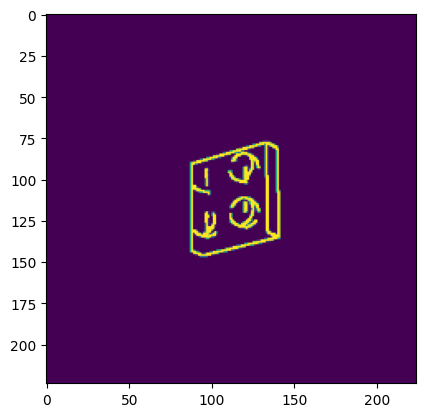

In [35]:
plt.imshow(X[500])

plt.show()

In [36]:
y[500]

'3022'

In [37]:
# Check the total number of classes
y.nunique()

4

In [38]:
# Get the actual class values
lego_classes = pd.Series(y).unique() # Convert y to a pandas Series
print(f"Lego Design Ids: {lego_classes}")

Lego Design Ids: ['3010' '3001' '2357' '3022']


In [39]:
y.shape

(1132,)

In [40]:
# Convert values to numpy arrays
X = np.array(X)
y = np.array(y)

In [41]:
X.shape, y.shape

((1132, 224, 224, 1), (1132,))

In [42]:
# Now we'll split our data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Checking if the length of training and testing data sets are same

In [43]:
# Print the length of each list
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

849
849
283
283


## Check if the image and labels match before augmentation

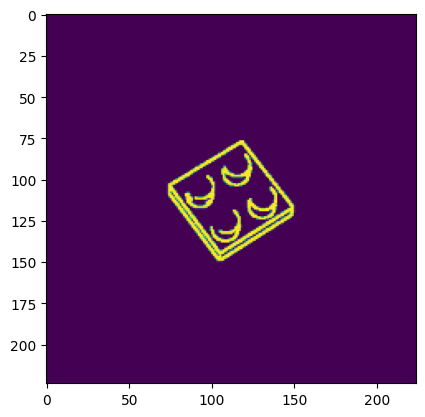

In [44]:
plt.imshow(X_train[100])

plt.show()

In [45]:
y_train[100]

'3022'

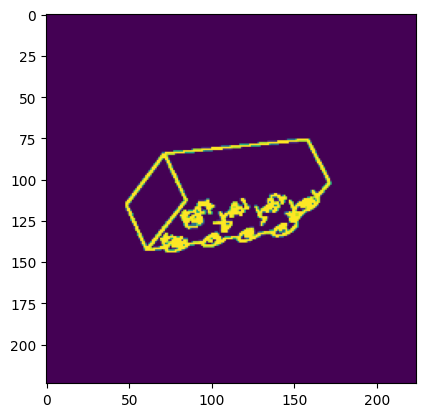

In [46]:
plt.imshow(X_test[281])

plt.show()

In [47]:
y_test[281]

'3001'

## Augmentation

In [48]:

# Apply augmentation to the whole training dataset

# Define the augmentation pipeline
data_augmentation = tf.keras.Sequential([

    tf.keras.layers.RandomFlip('horizontal'), # Random horizontal flip
    tf.keras.layers.RandomZoom(0.2),  # Random zoom (20%)
    tf.keras.layers.RandomFlip('vertical'),

])

# Create variables to hold the X and y training data
X_train_aug = []
y_train_aug = []

# Loop through all the images.
for i in range(len(X_train)):
      img = X_train[i]
      label = y_train[i]



    # Ensure that the input data has the correct shape
      img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Add 12 images for every original image
      for j in range(12):
          X_train_aug.append(data_augmentation(img, training=True)[0].numpy())
          y_train_aug.append(label)


# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))



10188
10188


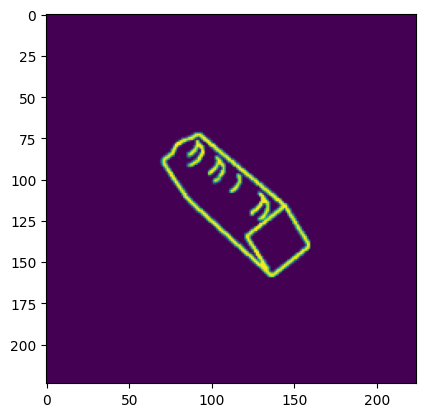

In [49]:
plt.imshow(X_train_aug[5])

plt.show()

In [50]:
y_train_aug[5]



'3010'

In [51]:


# Reshape test data for the model
X_test_np = []
for img in X_test:
  # Add a channel dimension for grayscale images

    X_test_np.append(img)

# Convert to numpy array
X_test_np = np.array(X_test_np)

# Check the shape of the first image
X_test_np[5].shape



(224, 224, 1)

# One hot Encoding of the target column

In [52]:
#One hot encode the y data

y_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train_aug).reshape(-1, 1))
y_train_aug_enc = y_encoder.transform(np.array(y_train_aug).reshape(-1, 1))
y_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))


In [53]:
# Convert values to numpy arrays

#Augmentation code
X_train_aug_np = np.array(X_train_aug)
X_test_np = np.array(X_test_np)
y_train_aug_np = np.array(y_train_aug_enc)
y_test_np = np.array(y_test_enc)



## Check the shapes of augmented X and Y for batch dimensions

In [54]:
X_train_aug_np.shape

(10188, 224, 224, 1)

In [55]:
X_test_np.shape

(283, 224, 224, 1)

In [56]:
y_test_np.shape

(283, 4)

In [57]:
y_train_aug_np.shape

(10188, 4)

In [58]:
# Split the training dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_aug_np, y_train_aug_np, test_size=0.3, random_state=42)

## Creating a CNN model

### Model1 - My current model

In [53]:
# Define a CNN model

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras import initializers


model1 = keras.Sequential([

    #Layer 1
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(224, 224, 1)),
    layers.MaxPooling2D((2, 2)),

    #Layer 2
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.0001)),
    layers.MaxPooling2D((2, 2)),

    #Layer 3
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.0001)),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    #Layer 4
    layers.Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0001)),
    layers.Dropout(0.3),

    #Layer 5
    layers.Dense(4, activation='softmax')
])



#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model

model1.compile(optimizer=Adam(learning_rate=0.00003), loss='categorical_crossentropy', metrics=['accuracy'])
#model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',AUC()])


# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=5,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with the callback
history = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)
# Evaluate the model using the testing data
model1.evaluate(X_test_np, y_test_np)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.5986 - loss: 0.9758 - val_accuracy: 0.8240 - val_loss: 0.5096
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8288 - loss: 0.4859 - val_accuracy: 0.8714 - val_loss: 0.3704
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8911 - loss: 0.3457 - val_accuracy: 0.9022 - val_loss: 0.2897
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9191 - loss: 0.2713 - val_accuracy: 0.9146 - val_loss: 0.2550
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9373 - loss: 0.2298 - val_accuracy: 0.9336 - val_loss: 0.2130
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9475 - loss: 0.1951 - val_accuracy: 0.9450 - val_loss: 0.1891
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9642 - loss: 0.1576 - val_accuracy: 0.9565 - val_loss: 0.1628
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9686 - loss: 0.1403 - val_acc

[0.05952289327979088, 0.9929328560829163]

## Model1 Evaluation

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9944 - loss: 0.0571 

Test Accuracy: 99.29%
Test Loss: 0.0595


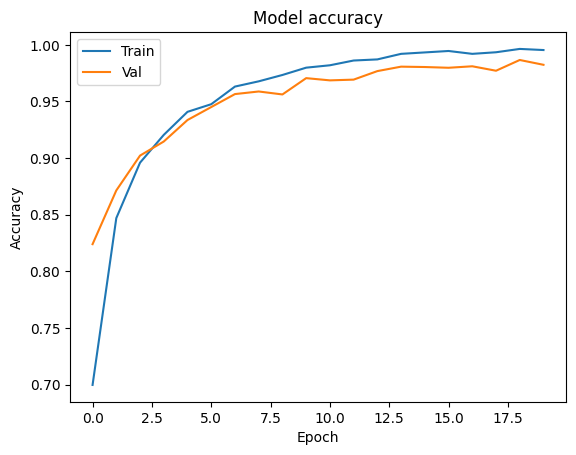

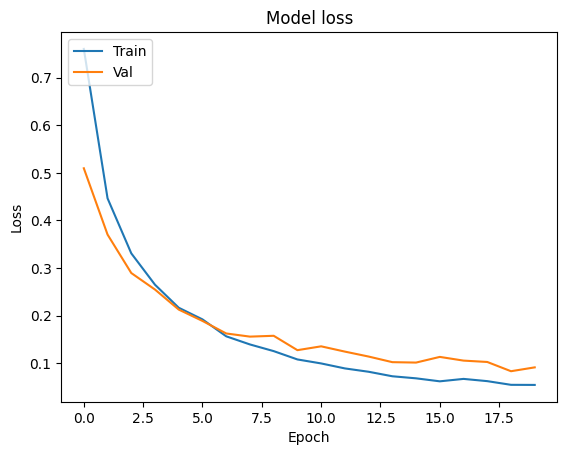

In [54]:
# Evaluate the model using the testing data
test_results= model1.evaluate(X_test_np, y_test_np)
print(f"\nTest Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Loss: {test_results[0]:.4f}")


# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Model1 Predictions

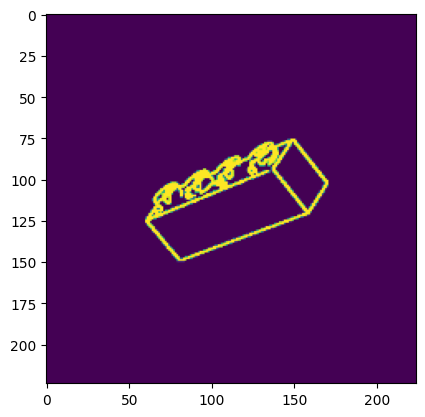

y label: 3010

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
Class 0: 0.000%
Class 1: 0.003%
Class 2: 99.997%
Class 3: 0.000%
Prediction Probabilities: [[7.604181e-11 2.844520e-05 9.999715e-01 6.545110e-10]]

Predicted Lego ID: 3010


In [59]:
# Make predictions

img_id = 5
lego_bricks = { 0:"2357",
               1:"3001",
               2:"3010",
               3:"3022"}

input_image = X_test[img_id]

plt.imshow(X_test[img_id])
plt.show()

print(f"y label: {y_test[img_id]}\n")

# Add a batch dimension:
input_image = input_image[np.newaxis, ...]
prediction = model1.predict(input_image)
lego_class = np.argmax(prediction)   # Lego with high probability

#for i, prob in enumerate(prediction[0]):
#    percentage = prob * 100
#    print(f"Lego Brick ID {lego_classes[i]}: {percentage:.3f}%")

node_values = prediction[0]  # First image in the batch

# Print node values
for i, value in enumerate(node_values):
  percentage = value * 100
  #print(f"Class {i}: {value:.2f}. ")
  print(f"Class {i}: {percentage:.3f}%")

predicted_class = np.argmax(node_values)
#print(f"\nPredicted Class: {predicted_class}")

print(f"Prediction Probabilities: {prediction}")

print(f"\nPredicted Lego ID: {lego_bricks[predicted_class]}")





In [62]:
from google.colab import drive
import pickle

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
model1.save('/content/drive/MyDrive/model1_trained.keras')  # Save model
#model = keras.models.load_model('/content/drive/MyDrive/model_checkpoint.keras')

In [64]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,012,046 (255.63 MB)

 Trainable params: 22,337,348 (85.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,674,698 (170.42 MB)

# Model 2 - L1 Regularization

In [58]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras import initializers

model2 = keras.Sequential([

    #Layer 1
    layers.Conv2D(64, (3, 3), activation='relu',input_shape=(224, 224, 1)),
    layers.MaxPooling2D((2, 2)),

    #Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #Layer 3
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l1(0.01)),
    layers.MaxPooling2D((2, 2)),

    #Layer 4
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l1(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    #Layer 5
    layers.Dense(512, activation='relu',kernel_regularizer=keras.regularizers.l1(0.01)),

    #Layer 6
    layers.Dense(4, activation='softmax')
])

# Compile the model

model2.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])


# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=7,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with the callback
history = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)
# Evaluate the model using the testing data
model2.evaluate(X_test_np, y_test_np)


Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.4196 - loss: 668.7193 - val_accuracy: 0.5787 - val_loss: 156.8397
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.4757 - loss: 90.0768 - val_accuracy: 0.2640 - val_loss: 22.4102
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.2592 - loss: 19.0852 - val_accuracy: 0.2640 - val_loss: 10.5377
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.2671 - loss: 8.5077 - val_accuracy: 0.2640 - val_loss: 3.8494
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.2621 - loss: 3.1067 - val_accuracy: 0.2640 - val_loss: 2.0091
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.2699 - loss: 1.9628 - val_accuracy: 0.2640 - val_loss: 1.9432
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.2581 - loss: 1.9434 - val_accuracy: 0.2640 - val_loss: 1.9430
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.2555 - loss: 

[1.9465649127960205, 0.20494699478149414]

# Model2 - Evaluation

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2122 - loss: 1.9454

Test Accuracy: 20.49%
Test Loss: 1.9466


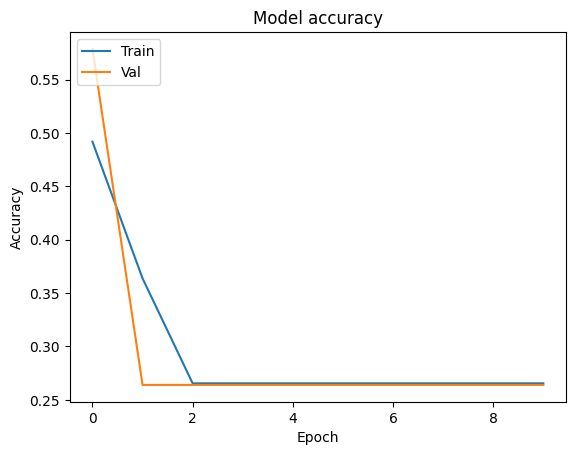

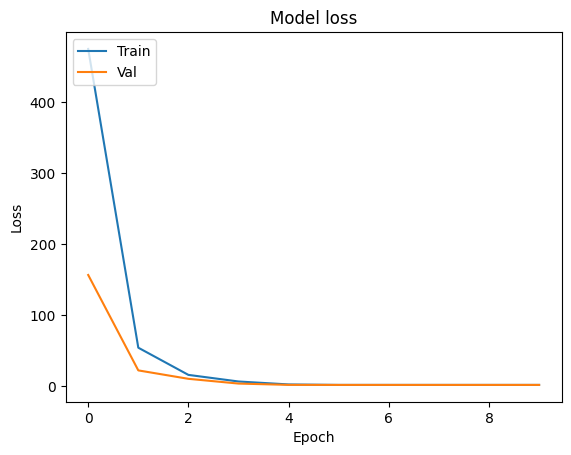

In [59]:
# Evaluate the model using the testing data
test_results= model2.evaluate(X_test_np, y_test_np)
print(f"\nTest Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Loss: {test_results[0]:.4f}")


# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
model2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ (None, 222, 222, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,096,270 (110.99 MB)

 Trainable params: 9,698,756 (37.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,397,514 (74.00 MB)

# Model 4 - L2 Regularization

In [61]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras import initializers

model4 = keras.Sequential([

    #Layer 1
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(224, 224, 1)),
    layers.MaxPooling2D((2, 2)),


    #Layer 2
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.03)),
    layers.MaxPooling2D((2, 2)),

    #Layer 3
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.03)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    #Layer 4
    layers.Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),

    #Layer 5
    layers.Dense(4, activation='softmax')
])

# Compile the model

model4.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])


# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=5,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with the callback
history = model4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=32,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)
# Evaluate the model using the testing data
model4.evaluate(X_test_np, y_test_np)


Epoch 1/12
223/223 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.6634 - loss: 5.8707 - val_accuracy: 0.8476 - val_loss: 3.6568
Epoch 2/12
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.8523 - loss: 3.2641 - val_accuracy: 0.8813 - val_loss: 2.3242
Epoch 3/12
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.9020 - loss: 2.0623 - val_accuracy: 0.9136 - val_loss: 1.5253
Epoch 4/12
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.9259 - loss: 1.3772 - val_accuracy: 0.9254 - val_loss: 1.0645
Epoch 5/12
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9489 - loss: 0.9526 - val_accuracy: 0.9421 - val_loss: 0.7883
Epoch 6/12
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9593 - loss: 0.7036 - val_accuracy: 0.9519 - val_loss: 0.6275
Epoch 7/12
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9721 - loss: 0.5396 - val_accuracy: 0.9591 - val_loss: 0.5154
Epoch 8/12
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9723 - loss: 0.4450 - 

[0.29814162850379944, 0.9611307382583618]

## Model 4 - Evaluations

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9512 - loss: 0.2978

Test Accuracy: 96.11%
Test Loss: 0.2981


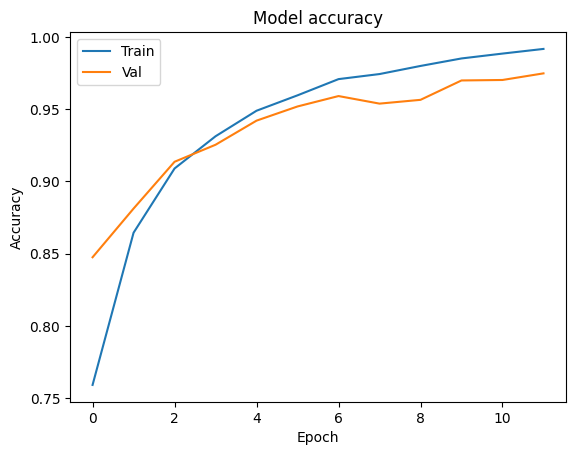

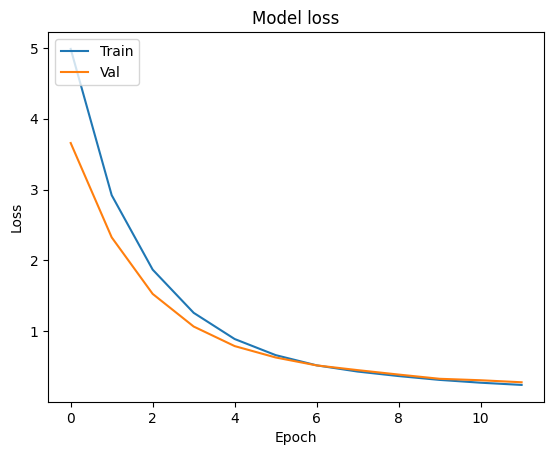

In [62]:
# Evaluate the model using the testing data
test_results= model4.evaluate(X_test_np, y_test_np)
print(f"\nTest Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Loss: {test_results[0]:.4f}")


# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [63]:
model4.save('/content/drive/MyDrive/model4_trained.keras')

# Model3 - With dropouts

In [64]:
# Define a basic CNN model

from tensorflow.keras.initializers import HeNormal

model3 = keras.Sequential([

    #Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    layers.MaxPooling2D((2, 2)),

    #Layer 2
    layers.Conv2D(128, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    #Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    #Layer 4
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),

    #Layer 5
    layers.Dense(4, activation='softmax')
])

# Compile the model

model3.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# Train the model with the callback
history = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model using the testing data
model3.evaluate(X_test_np, y_test_np)


Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.6475 - loss: 0.8336 - val_accuracy: 0.8587 - val_loss: 0.3698
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.8585 - loss: 0.3623 - val_accuracy: 0.9104 - val_loss: 0.2485
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9078 - loss: 0.2428 - val_accuracy: 0.9078 - val_loss: 0.2142
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9378 - loss: 0.1780 - val_accuracy: 0.9441 - val_loss: 0.1527
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9570 - loss: 0.1274 - val_accuracy: 0.9611 - val_loss: 0.1068
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9696 - loss: 0.0932 - val_accuracy: 0.9676 - val_loss: 0.0909
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9720 - loss: 0.0790 - val_accuracy: 0.9722 - val_loss: 0.0838
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9816 - loss: 0.0591 - 

[0.05483628064393997, 0.9787985682487488]

# Model 3 Evaluations

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9775 - loss: 0.0553

Test Accuracy: 97.88%
Test Loss: 0.0548


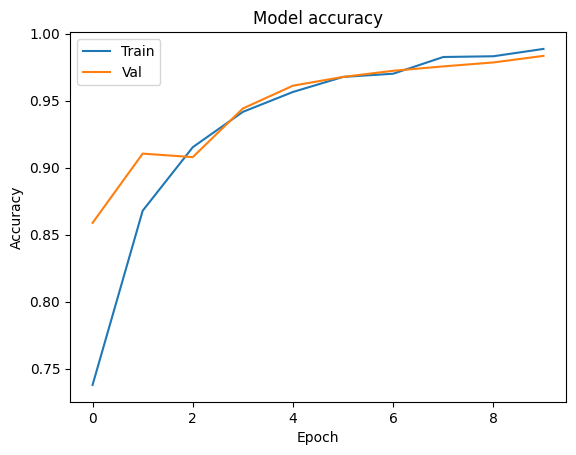

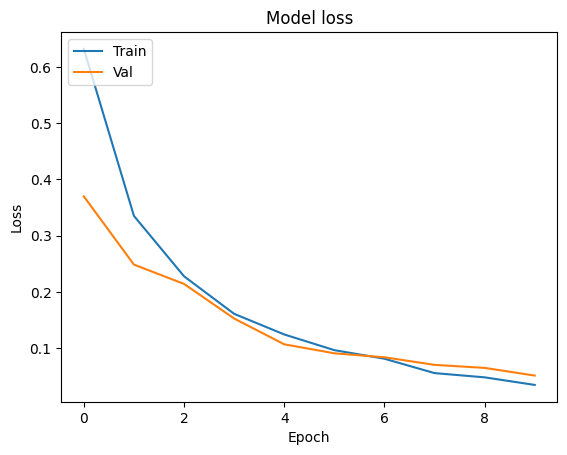

In [65]:
# Evaluate the model using the testing data
test_results= model3.evaluate(X_test_np, y_test_np)
print(f"\nTest Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Loss: {test_results[0]:.4f}")

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [66]:
model3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 109, 109, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 52, 52, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,012,046 (255.63 MB)

 Trainable params: 22,337,348 (85.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,674,698 (170.42 MB)

In [67]:
model3.save('/content/drive/MyDrive/model3_trained.keras')

## Hyperparameter tuning - Random search

In [ ]:

!pip install keras-tuner -q

import keras
from keras import layers
from keras_tuner import HyperModel, RandomSearch
import tensorflow as tf

# Define a model using HyperModel (used for hyperparameter tuning)
class CNNHyperModel(HyperModel):
    def build(self, hp):
        # Create a Sequential model
        model3 = keras.Sequential()

        # Hyperparameters for Conv2D layers
        model3.add(layers.Conv2D(
            filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=(224, 224, 3)
        ))
        model3.add(layers.MaxPooling2D((2, 2)))

        model3.add(layers.Conv2D(
            filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model3.add(layers.MaxPooling2D((2, 2)))

        model3.add(layers.Conv2D(
            filters=hp.Int('conv_3_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model3.add(layers.Flatten())

        # Hyperparameter for Dense layer
        model3.add(layers.Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
            activation='relu'
        ))

        # Output layer
        model3.add(layers.Dense(4, activation='softmax'))  # Binary classification

        # Compile the model
        model3.compile(
            optimizer=keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model3


# Instantiate the HyperModel
cnn_hypermodel = CNNHyperModel()

# Define the hyperparameter search
tuner = RandomSearch(
    cnn_hypermodel,
    objective='val_accuracy',  # We aim to optimize validation accuracy
    max_trials=5,               # Number of different hyperparameter combinations to test
    executions_per_trial=3,     # How many times to train each model
    directory='tuner_dir',      # Directory to save the results
    project_name='cnn_batch_tuning'  # Project name
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=32)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test data
best_model.evaluate(X_test_np, y_test_np)





Trial 5 Complete [00h 10m 02s]
val_accuracy: 0.32159624497095746

Best val_accuracy So Far: 0.3262910743554433
Total elapsed time: 00h 52m 41s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.2171 - loss: 6.6949


[6.253284454345703, 0.23591549694538116]

In [ ]:

# Print best hyperparameters
print("Best Hyperparameters Found:")
for param in best_hyperparameters.values:  # Use best_hyperparameters instead of best_hps
    print(f"{param}: {best_hyperparameters.get(param)}")

Best Hyperparameters Found:
conv_1_filters: 32
conv_2_filters: 128
conv_3_filters: 128
dense_units: 128


#Gradio application code

In [60]:
# Import Gradio
import gradio as gr
import pyttsx3



## Python offline text to speech code [Pyttsx library]

In [61]:
#Initialize the TTS engine
engine=pyttsx3.init()

def spell_out_number(number_str):
    return ' '.join(number_str)


#Funciton to convert text to speech
def text_to_speech(text):

    engine.setProperty('rate', 200)

    # Spell digits in the text
    words = text.split()
    spoken_words = []
    for word in words:
        if word.isdigit():
            spoken_words.append(spell_out_number(word))
        else:
            spoken_words.append(word)
    spoken_text = ' '.join(spoken_words)

    engine.save_to_file(spoken_text, "output.wav")
    engine.runAndWait()
    return "output.wav"

In [85]:
!pip install python-dotenv
import openai
import os
from dotenv import load_dotenv
from openai import OpenAI



load_dotenv()
print(load_dotenv())

print(os.getenv("OPENAI_API_KEY"))

False
None


## OpenAI text to speech module

In [76]:




# Set your API key

openai_api_key = os.getenv("OPENAI_API_KEY")

def spell_out_number(number_str):
    return ' '.join(number_str)


#Funciton to convert text to speech
def text_to_speech_openai(text):



    # Spell digits in the text
    words = text.split()
    spoken_words = []
    for word in words:
        if word.isdigit():
            spoken_words.append(spell_out_number(word))
        else:
            spoken_words.append(word)
    spoken_text = ' '.join(spoken_words)

    response = openai.audio.speech.create(
        model="tts-1",  # or "tts-1-hd"
        voice="nova",  # Options: alloy, echo, fable, onyx, nova, shimmer
        input=text
    )
    output_path = "output_openai.wav"
    response.stream_to_file(output_path)
    return output_path



In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Gradio - Input image processing

In [77]:
# process image function called from Gradio application

def process_image(img):
  lego_bricks = {
               0:"2357",
               1:"3001",
               2:"3010",
               3:"3022"}

  kernel = np.ones((3, 3), np.uint8)

  # Image pre-processing
  array_input = np.array(img)
  edges_input=cv2.Canny(array_input,50,150)

  dilated_edges_input = cv2.dilate(edges_input, kernel, iterations=1)
  resized_image_input = cv2.resize(dilated_edges_input, (100, 100))

  # Add padding to make it 224x224

  top = bottom = (224 - 100) // 2
  left = right = (224 - 100) // 2
  padded_image = cv2.copyMakeBorder(resized_image_input, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

  expanded_edges_input = np.stack((padded_image,) * 1, axis=-1)


  float_image_input = np.array(expanded_edges_input).astype(np.float32)

  normalized_image_input = float_image_input/255
  print(np.array(normalized_image_input).min(), np.array(normalized_image_input).max())
  normalized_image_input.shape
  normalized_image_input = np.expand_dims(normalized_image_input, axis=0)

  #Model prediction
  predict_input_image= model1.predict(normalized_image_input)
  predicted_class = np.argmax(predict_input_image)  # Get class index


  probability_lines=[]
  probs = predict_input_image[0]

  probability_lines = [

        f"Class {i} : Lego brick ID {lego_bricks[i]} :Probability {prob * 100:.2f}%"
        for i, prob in enumerate(probs)
    ]


  probabilities_text = "\n".join(probability_lines)

  # Spelled-out voice output
  brick_id = lego_bricks[predicted_class]
  info_text = f"The Lego is: {brick_id}"
  audio_path = text_to_speech_openai(info_text)

  return probabilities_text, audio_path

## Gradio app Interface and Launch

In [78]:
#image_path = "C:/Users/Owner/Git_Local/project3_prep/Demo_images/300121.jpg"
app = gr.Interface(


    fn=process_image,  # Function to call
    inputs=gr.Image(type="pil"),  # Input type (image)
    outputs=[
              gr.Textbox(label="Lego probability"),
              gr.Audio(label="Generated speech",type="filepath"),
              ],
    submit_btn="Predict Lego Brick",
    title="LEGO Type Classifier",
    description="Upload an image of a LEGO brick to classify its type.",

)

app.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://289e761e85836c2ab8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


0.0 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2137, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1663, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://289e761e85836c2ab8.gradio.live
